# gcm_filters Test

This notebook is for learning how to use the `gcm_filters` package to smooth gridded data. Dhruv said this package is adventageous because it handles boundaries well and also returns a dataset on the same grid it was provided on.

The goal here is to do 2 things to the diffusivity datasets from Argo: 
1. fill in the gaps of the diffusivity dataset and expand the spatial extent farther north and south
2. smooth the diffusivity dataset (there's more information here than we need)

To fill in gaps, you should use the median value on that density surfce. Also make sure that every point everywhere has a value in the diffusivity dataset, that way the Argo gradient data is what determines where there will be values. 

After this, use gcm_filters to smooth (regular filters with nans? is this the name of a function or an example notebook or what?).

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
import gcm_filters

In [2]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat'
    }).rename_vars({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat'
    })

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'PRES_INTERPOLATED'}
    }, periodic=['X'])

    return ds_gridded, grid

In [ ]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [3]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [6]:
%%time
ds_gridded, grid = get_ds_gridded(ds, lon_bins, lat_bins)

CPU times: user 18min 31s, sys: 11min, total: 29min 31s
Wall time: 30min 17s


In [7]:
ds_gridded

<xarray.Dataset> Size: 454MB
Dimensions:            (PRES_INTERPOLATED: 1001, lon: 120, lat: 59,
                        lon_left: 120, lat_left: 59)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * lon                (lon) float64 960B -178.5 -175.5 -172.5 ... 175.5 178.5
  * lat                (lat) float64 472B -87.0 -84.0 -81.0 ... 81.0 84.0 87.0
  * lon_left           (lon_left) float64 960B -180.0 -177.0 ... 174.0 177.0
  * lat_left           (lat_left) float64 472B -88.5 -85.5 -82.5 ... 82.5 85.5
Data variables:
    CT                 (PRES_INTERPOLATED, lon, lat) float64 57MB nan ... nan
    CYCLE_NUMBER       (PRES_INTERPOLATED, lon, lat) float64 57MB nan ... nan
    PLATFORM_NUMBER    (PRES_INTERPOLATED, lon, lat) float64 57MB nan ... nan
    PRES               (PRES_INTERPOLATED, lon, lat) float32 28MB nan ... nan
    PSAL               (PRES_INTERPOLATED, lon, lat) float32 28MB nan ... nan
    SA                 (PRES_INTERPOLATED, lon, lat) float64 57MB nan ... nan
    SIG0               (PRES_INTERPOLATED, lon, lat) float64 57MB nan ... nan
    TEMP               (PRES_INTERPOLATED, lon, lat) float32 28MB nan ... nan
    sample_rate        (PRES_INTERPOLATED, lon, lat) float32 28MB nan ... nan
    SPICE              (PRES_INTERPOLATED, lon, lat) float64 57MB nan ... nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [8]:
ds_gridded.to_netcdf('/swot/SUM05/amf2288/sync-boxes/ds_gridded_3_z.nc')

In [12]:
ds_diff = xr.open_dataset('/swot/SUM05/amf2288/global_kappa_epsilon.nc')

In [13]:
ds_p_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_p_grid_copilot.nc').drop_vars(['LON_left','LAT_left'])

In [14]:
ds_diff = ds_diff.interp(z=ds_p_grid.PRESSURE).rename({'lon':'LON','lat':'LAT'}).drop_vars('z')

In [15]:
def align_diff_coords(ds_diff, ds_gridded, lon_name="LON", lat_name="LAT", left_suffix="_left"):
    """
    Adjust lon and lat coordinates of ds_diff to match ds_gridded:
    - Convert lon from (0, 360) to (-180, 180)
    - Interpolate lat to match range and resolution of ds_gridded
    - Apply same to *_left coordinates if present
    """
    import xarray as xr
    import numpy as np

    # 1. Transform longitude to (-180, 180)
    def wrap_lon(lon):
        return ((lon + 180) % 360) - 180

    ds_diff[lon_name] = wrap_lon(ds_diff[lon_name])
    if f"{lon_name}{left_suffix}" in ds_diff.coords:
        ds_diff[f"{lon_name}{left_suffix}"] = wrap_lon(ds_diff[f"{lon_name}{left_suffix}"])

    # Ensure sorted for interpolation (important if wrap reverses order)
    ds_diff = ds_diff.sortby(lon_name)
    ds_diff = ds_diff.sortby(lat_name)

    # 2. Interpolate lat to match ds_gridded
    lat_target = ds_gridded[lat_name]
    ds_diff_interp = ds_diff.interp({lat_name: lat_target}, method="nearest")

    # Optionally expand *_left latitude to match
    if f"{lat_name}{left_suffix}" in ds_diff.coords:
        left_target = ds_gridded[f"{lat_name}{left_suffix}"]
        ds_diff_interp.coords[f"{lat_name}{left_suffix}"] = left_target

    return ds_diff_interp


In [16]:
ds_diff = align_diff_coords(ds_diff, ds_p_grid)

In [17]:
ds_diff = generate_grid_ds(ds_diff, {'X':'LON', 'Y':'LAT'})
grid = Grid(ds_diff, coords={
        'X': {'center': 'LON'},
        'Y': {'center': 'LAT'},
        'Z': {'center': 'PRESSURE'}
        }, periodic=['X'])

In [18]:
ds_diff

<xarray.Dataset> Size: 115MB
Dimensions:   (PRESSURE: 1001, LON: 120, LAT: 60, LON_left: 120, LAT_left: 60)
Coordinates:
  * LON       (LON) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * PRESSURE  (PRESSURE) int64 8kB 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
  * LAT       (LAT) float64 480B -88.5 -85.5 -82.5 -79.5 ... 79.5 82.5 85.5 88.5
  * LON_left  (LON_left) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
  * LAT_left  (LAT_left) float64 480B -90.0 -87.0 -84.0 -81.0 ... 81.0 84.0 87.0
Data variables:
    K         (PRESSURE, LON, LAT) float64 58MB nan nan nan nan ... nan nan nan
    e         (PRESSURE, LON, LAT) float64 58MB nan nan nan nan ... nan nan nan

## Fill Nans

In [19]:
def fill_nans_with_median(ds, varnames=("K", "e"), dim="PRESSURE"):
    """
    For each variable in varnames, fill NaNs using the median along the specified dimension.
    Median is computed across (lon, lat) for each pressure level.
    """
    import xarray as xr
    import numpy as np

    filled = {}
    for var in varnames:
        # Compute median per pressure level ignoring NaNs
        median = ds[var].median(dim=["LON", "LAT"], skipna=True)

        # Broadcast to full shape
        median_expanded = median.broadcast_like(ds[var])

        # Replace NaNs
        filled[var] = ds[var].where(ds[var].notnull(), median_expanded)

    return ds.assign(**filled)


In [20]:
ds_diff_nanless = fill_nans_with_median(ds_diff)

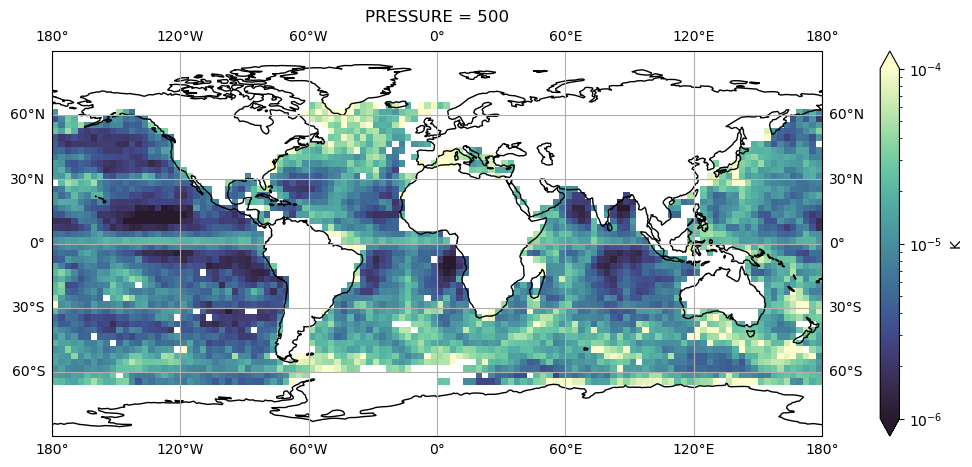

In [22]:
depth = 500

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_diff.K.sel(PRESSURE=depth, method='nearest').plot(x='LON',y='LAT',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))

Text(0.5, 1.0, 'K_rho, depth=400m, ORIGINAL')

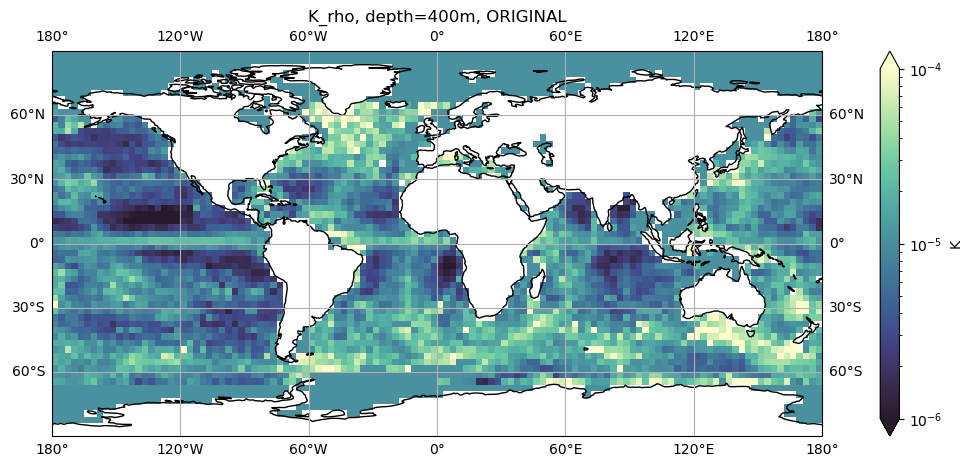

In [57]:
depth = 400

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_diff_nanless.K.where(land_mask_resampled).sel(PRESSURE=depth, method='nearest').plot(x='LON',y='LAT',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
plt.title(f'K_rho, depth={depth}m, ORIGINAL')

## Filter Field

In [24]:
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND)

['wet_mask']

In [45]:
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin = basin.rename({'X': 'LON', 'Y': 'LAT'})
basin

<xarray.Dataset> Size: 9MB
Dimensions:  (LON: 360, LAT: 180, Z: 33)
Coordinates:
  * LON      (LON) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * LAT      (LAT) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 132B 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    basin    (Z, LAT, LON) float32 9MB ...
Attributes:
    Conventions:  IRIDL

In [47]:
land_mask = xr.where(basin_surf.notnull(), 1, 0)
land_mask

<xarray.DataArray 'basin' (LAT: 180, LON: 360)> Size: 518kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
  * LON      (LON) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * LAT      (LAT) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    Z        float32 4B 0.0

In [48]:
print(ds_diff_nanless)

<xarray.Dataset> Size: 115MB
Dimensions:   (PRESSURE: 1001, LON: 120, LAT: 60, LON_left: 120, LAT_left: 60)
Coordinates:
  * LON       (LON) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * PRESSURE  (PRESSURE) int64 8kB 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
  * LAT       (LAT) float64 480B -88.5 -85.5 -82.5 -79.5 ... 79.5 82.5 85.5 88.5
  * LON_left  (LON_left) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
  * LAT_left  (LAT_left) float64 480B -90.0 -87.0 -84.0 -81.0 ... 81.0 84.0 87.0
Data variables:
    K         (PRESSURE, LON, LAT) float64 58MB nan nan nan nan ... nan nan nan
    e         (PRESSURE, LON, LAT) float64 58MB nan nan nan nan ... nan nan nan


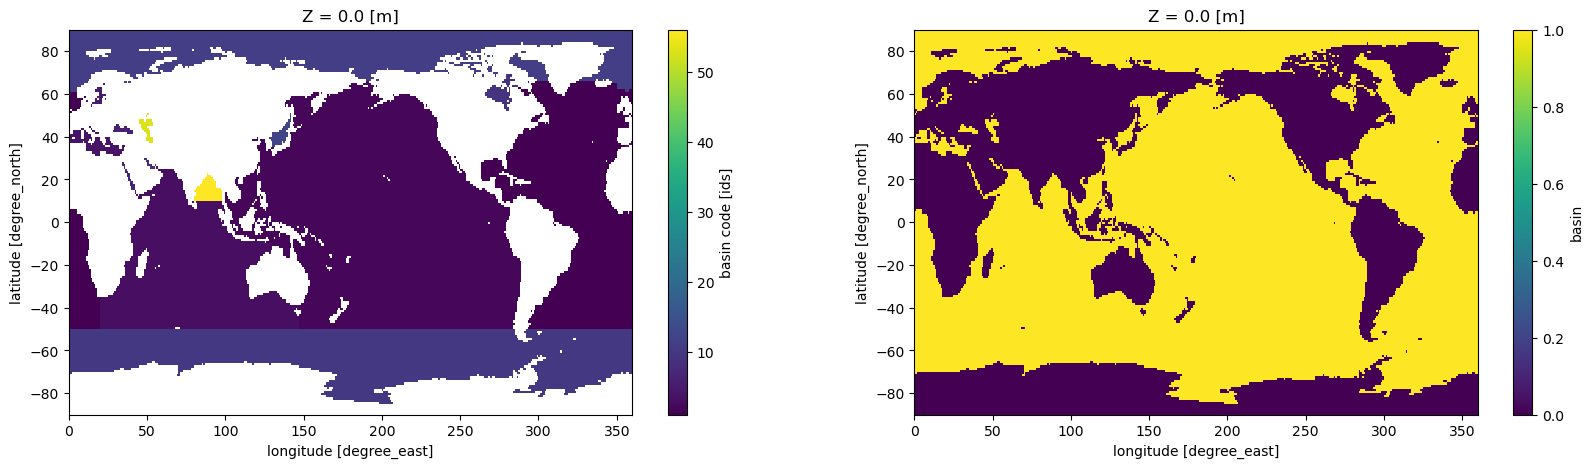

In [46]:
basin_surf = basin.basin[0]

plt.figure(figsize=(20,5))
plt.subplot(121)
basin_surf.plot()

plt.subplot(122)
land_mask.plot()

In [51]:
def prepare_land_mask(land_mask, ds_target, method="nearest"):
    """
    Shifts land_mask longitude from (0, 360) to (-180, 180) and resamples to match ds_target grid.
    Ideal for binary masks (0 = ocean, 1 = land).
    """
    import xarray as xr

    # 1. Shift longitude from [0, 360) to [-180, 180)
    land_mask = land_mask.copy()
    land_mask["LON"] = ((land_mask["LON"] + 180) % 360) - 180
    land_mask = land_mask.sortby("LON")

    # 2. Interpolate to ds_target grid
    lat_target = ds_target["LAT"]
    lon_target = ds_target["LON"]

    resampled = land_mask.interp(
        LAT=lat_target,
        LON=lon_target,
        method=method
    ).astype("int8")

    # 3. Add metadata
    resampled.name = "land_mask_resampled"
    resampled.attrs.update({
        "description": "Binary mask of land (1) and ocean (0), resampled to match target grid",
        "source": "Shifted and interpolated from original land_mask",
        "method": method
    })

    return resampled

In [52]:
land_mask_resampled = prepare_land_mask(land_mask, ds_diff_nanless)

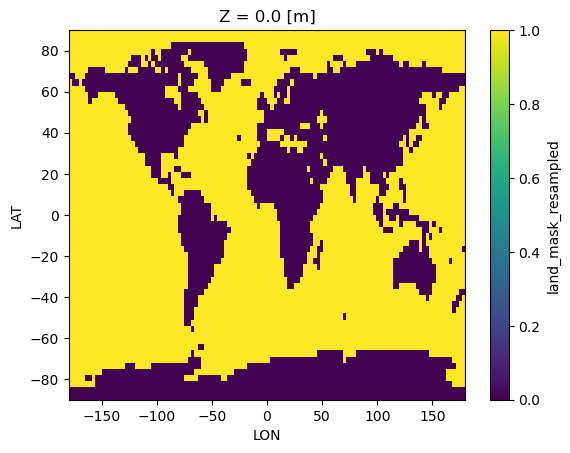

In [53]:
land_mask_resampled.plot()

In [55]:
dx = (ds_diff_nanless.LON.isel(LON=1) - ds_diff_nanless.LAT.isel(LAT=0)).values
dx

array(-87.)

In [58]:
filter_3dx = gcm_filters.Filter(filter_scale=dx*3,
                                dx_min=dx,
                                grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
                                grid_vars={'wet_mask':land_mask_resampled})

filter_5dx = gcm_filters.Filter(filter_scale=dx*5,
                                dx_min=dx,
                                grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
                                grid_vars={'wet_mask':land_mask_resampled})

filter_10dx = gcm_filters.Filter(filter_scale=dx*10,
                                dx_min=dx,
                                grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
                                grid_vars={'wet_mask':land_mask_resampled})

filter_15dx = gcm_filters.Filter(filter_scale=dx*15,
                                dx_min=dx,
                                grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
                                grid_vars={'wet_mask':land_mask_resampled})

In [59]:
filter_5dx

Filter(filter_scale=-435.0, dx_min=array(-87.), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=6, grid_type=<GridType.REGULAR_WITH_LAND: 3>)

In [60]:
K_masked = ds_diff_nanless.K.where(land_mask_resampled)

In [61]:
%%time
K_filt_3dx = filter_3dx.apply(K_masked, dims=['LON','LAT'])
K_filt_5dx = filter_5dx.apply(K_masked, dims=['LON','LAT'])
K_filt_10dx = filter_10dx.apply(K_masked, dims=['LON','LAT'])

CPU times: user 5.52 s, sys: 6.13 s, total: 11.6 s
Wall time: 11.7 s


In [66]:
K_filt_3dx.to_netcdf('/swot/SUM05/amf2288/K_rho_filt_p.nc')

Text(0.5, 1.0, 'K_rho, depth=400m, l=-435.0deg')

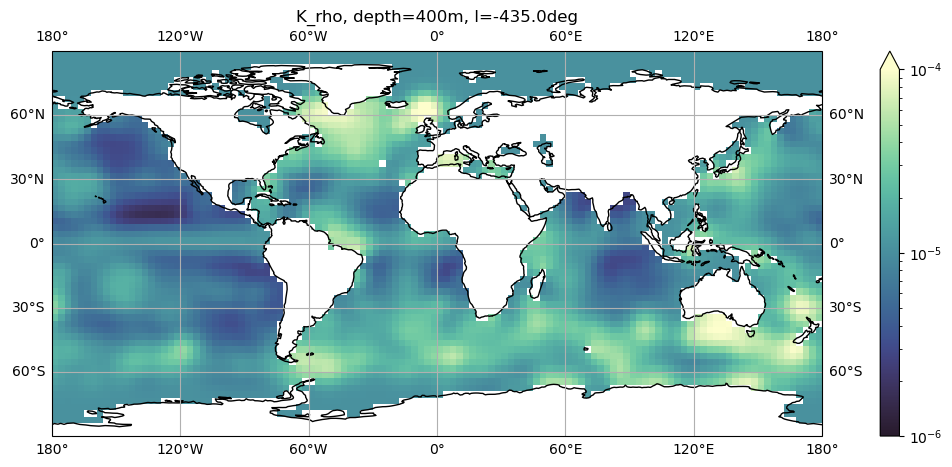

In [64]:
depth = 400
ds = K_filt_5dx

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(PRESSURE=depth, method='nearest').plot(x='LON',y='LAT',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
plt.title(f'K_rho, depth={depth}m, l={5*dx}deg')

## Interp to density

In [195]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    #ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.lat.data))
    #ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.lon.data))
    
    return ds_rho

In [196]:
K_filt_3dx = K_filt_3dx.to_dataset(name='K_filt_3dx')
K_filt_5dx = K_filt_5dx.to_dataset(name='K_filt_5dx')

In [203]:
da_SIG0_flat = ds_gridded.SIG0.stack(N_PROF=('lon', 'lat'))

ds_flat_3dx = K_filt_3dx.transpose('PRES_INTERPOLATED', 'lon', 'lat')
ds_flat_3dx = ds_flat_3dx.stack(N_PROF=('lon', 'lat'))

ds_flat_5dx = K_filt_5dx.transpose('PRES_INTERPOLATED', 'lon', 'lat')
ds_flat_5dx = ds_flat_5dx.stack(N_PROF=('lon', 'lat'))

In [204]:
rho_grid = np.arange(21,29,0.0025)

In [205]:
%%time
ds_rho_flat_3dx = get_ds_rho(ds_flat_3dx, da_SIG0_flat, rho_grid, variables=['K_filt_3dx'])
ds_rho_flat_5dx = get_ds_rho(ds_flat_5dx, da_SIG0_flat, rho_grid, variables=['K_filt_5dx'])

Completed comp for K_filt_3dx
Completed K_filt_3dx
Completed merge
Completed comp for K_filt_5dx
Completed K_filt_5dx
Completed merge
CPU times: user 5.2 s, sys: 353 ms, total: 5.55 s
Wall time: 5.54 s


In [207]:
da_back_3dx = ds_rho_flat_3dx['K_filt_3dx'].unstack('N_PROF')
da_back_3dx = da_back_3dx.transpose('rho_grid', 'lon', 'lat')
K_filt_3dx_rho = xr.Dataset({'K_filt_3dx': da_back_3dx}).rename({'rho_grid':'density'})

da_back_5dx = ds_rho_flat_5dx['K_filt_5dx'].unstack('N_PROF')
da_back_5dx = da_back_5dx.transpose('rho_grid', 'lon', 'lat')
K_filt_5dx_rho = xr.Dataset({'K_filt_5dx': da_back_5dx}).rename({'rho_grid':'density'})

Text(0.5, 1.0, 'K_rho, density=27.5m, l=9.0deg')

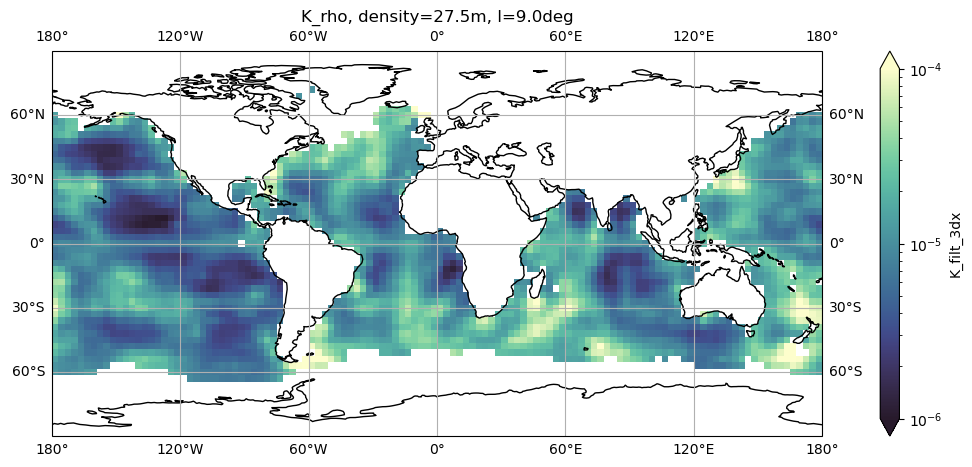

In [213]:
density = 27.5
ds = K_filt_3dx_rho.K_filt_3dx

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
plt.title(f'K_rho, density={density}m, l={3*dx}deg')

Text(0.5, 1.0, 'K_rho, density=27.5m, l=15.0deg')

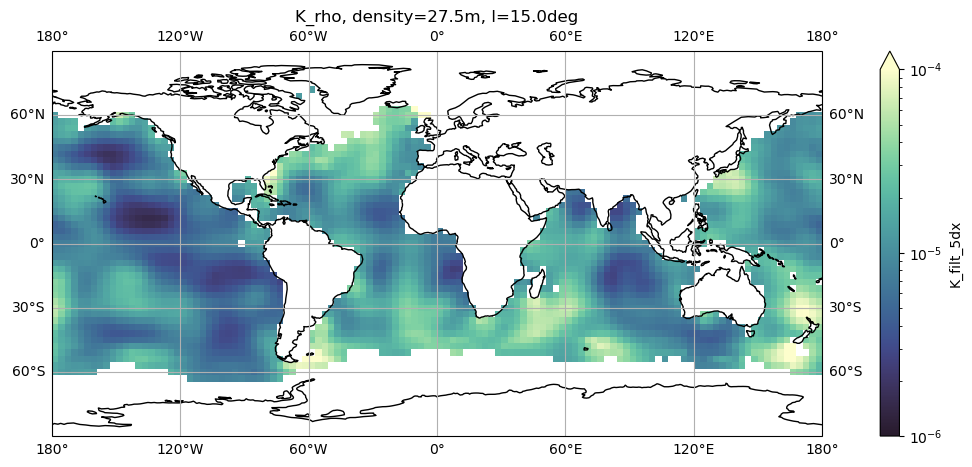

In [212]:
density = 27.5
ds = K_filt_5dx_rho.K_filt_5dx

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
plt.title(f'K_rho, density={density}m, l={5*dx}deg')

In [214]:
term2_ds = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2 = term2_ds.ct_e_z2_filt.rename('term2')
term3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()

In [215]:
K_rho_3dx = K_filt_3dx_rho.K_filt_3dx
K_rho_5dx = K_filt_5dx_rho.K_filt_5dx

In [216]:
K_e_3dx = K_rho_3dx*term2/term3
K_e_5dx = K_rho_5dx*term2/term3

Text(0.5, 1.0, 'K_e, density=27.5m, l=9.0deg')

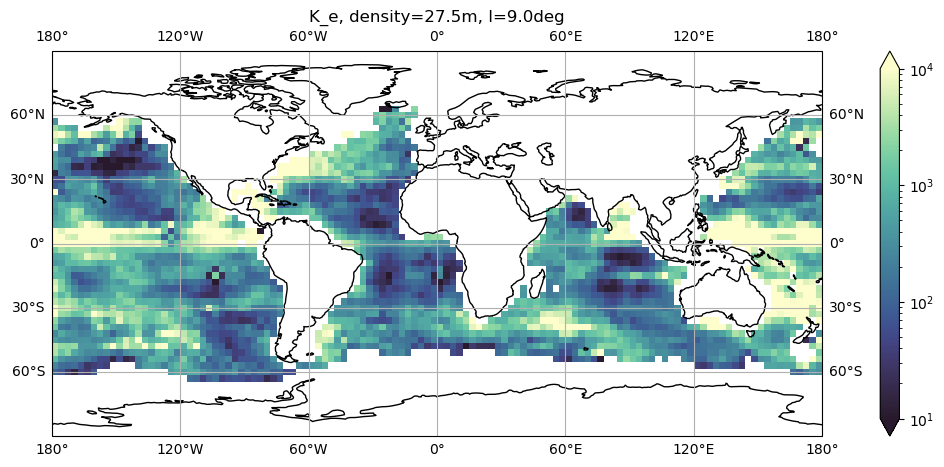

In [219]:
density = 27.5
ds = K_e_3dx

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e1, vmax=1e4))
plt.title(f'K_e, density={density}m, l={3*dx}deg')

Text(0.5, 1.0, 'K_e, density=27.5m, l=15.0deg')

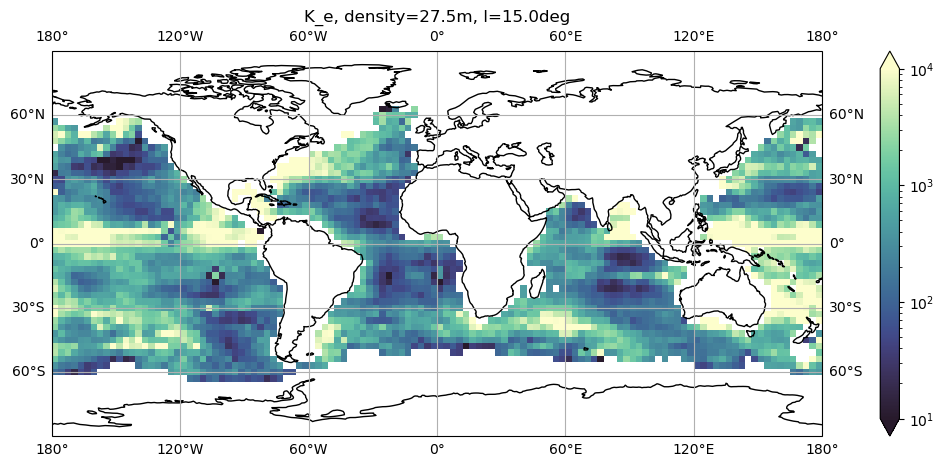

In [220]:
density = 27.5
ds = K_e_5dx

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e1, vmax=1e4))
plt.title(f'K_e, density={density}m, l={5*dx}deg')

In [223]:
ds_gridded = ds_gridded.drop_dims(['lon_left','lat_left'])

In [225]:
%%time
ds_flat = ds_gridded.transpose('PRES_INTERPOLATED', 'lon', 'lat')
ds_flat = ds_flat.stack(N_PROF=('lon', 'lat'))
ds_rho_flat= get_ds_rho(ds_flat, da_SIG0_flat, rho_grid, variables=['CT','SA','SIG0','SPICE','PRES'])

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES
Completed merge
CPU times: user 14.7 s, sys: 662 ms, total: 15.4 s
Wall time: 15.4 s


In [226]:
ds_rho_flat

<xarray.Dataset> Size: 816MB
Dimensions:   (rho_grid: 3200, N_PROF: 7080)
Coordinates:
  * rho_grid  (rho_grid) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * N_PROF    (N_PROF) object 57kB MultiIndex
  * lon       (N_PROF) float64 57kB -178.5 -178.5 -178.5 ... 178.5 178.5 178.5
  * lat       (N_PROF) float64 57kB -87.0 -84.0 -81.0 -78.0 ... 81.0 84.0 87.0
Data variables:
    CT        (N_PROF, rho_grid) float64 181MB nan nan nan nan ... nan nan nan
    SA        (N_PROF, rho_grid) float64 181MB nan nan nan nan ... nan nan nan
    SIG0      (N_PROF, rho_grid) float64 181MB nan nan nan nan ... nan nan nan
    SPICE     (N_PROF, rho_grid) float64 181MB nan nan nan nan ... nan nan nan
    PRES      (N_PROF, rho_grid) float32 91MB nan nan nan nan ... nan nan nan

In [227]:
ct_back = ds_rho_flat['CT'].unstack('N_PROF')
sa_back = ds_rho_flat['SA'].unstack('N_PROF')
sig0_back = ds_rho_flat['SIG0'].unstack('N_PROF')
spice_back = ds_rho_flat['SPICE'].unstack('N_PROF')
pres_back = ds_rho_flat['PRES'].unstack('N_PROF')
ct_back = ct_back.transpose('rho_grid', 'lon', 'lat')
sa_back = sa_back.transpose('rho_grid', 'lon', 'lat')
sig0_back = sig0_back.transpose('rho_grid', 'lon', 'lat')
spice_back = spice_back.transpose('rho_grid', 'lon', 'lat')
pres_back = pres_back.transpose('rho_grid', 'lon', 'lat')
ds_gridded_rho = xr.Dataset({'CT': ct_back, 'SA':sa_back, 'SIG0':sig0_back, 'SPICE':spice_back, 'PRES':pres_back}).rename({'rho_grid':'density'})

In [231]:
K_e_3dx

<xarray.DataArray (density: 3200, lon: 120, lat: 45)> Size: 138MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat      (lat) float64 360B -66.0 -63.0 -60.0 -57.0 ... 57.0 60.0 63.0 66.0
  * density  (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0

In [232]:
K_rho_3dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc')
K_rho_5dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/K_rho_5dx.nc')

In [230]:
K_e_3dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/K_e_3dx.nc')
K_e_5dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/K_e_5dx.nc')
ds_gridded.to_netcdf('/swot/SUM05/amf2288/sync-boxes/ds_gridded_x.nc')
ds_gridded_rho.to_netcdf('/swot/SUM05/amf2288/sync-boxes/ds_gridded_rho.nc')